<IPython.core.display.Javascript object>


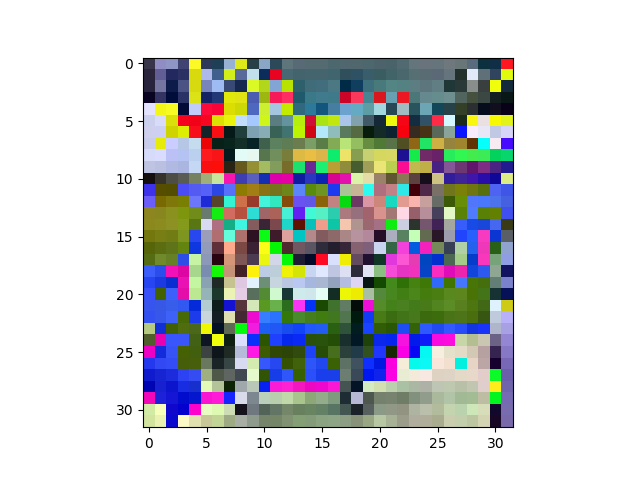

In [1]:
# Nathan Tibbetts
# Lab 5 - Your First Image Classifier
%matplotlib notebook

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cPickle

def unpickle( file ):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

# load cifar-10-small and project down
 
data1 = unpickle( 'cifar-10-batches-py/data_batch_1' )
data2 = unpickle( 'cifar-10-batches-py/data_batch_2' )
data3 = unpickle( 'cifar-10-batches-py/data_batch_3' )
data4 = unpickle( 'cifar-10-batches-py/data_batch_4' )
data5 = unpickle( 'cifar-10-batches-py/data_batch_5' )
data6 = unpickle( 'cifar-10-batches-py/test_batch' )
 
features = np.vstack((data1['data'],data2['data'],data3['data'],
                      data4['data'],data5['data'],data6['data']))
labels = np.hstack((data1['labels'],data2['labels'],data3['labels'],
                    data4['labels'],data5['labels'],data6['labels']))
#labels = np.atleast_2d( labels )
# data1['batch_label'] --> "training batch 1 of 5"
# print np.shape(labels)

N = np.shape(features)[0]
 
# only keep N items
# features = features[ 0:N, : ]
# labels = labels[ : , 0:N ]

# whiten our data - zero mean and unit standard deviation
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
#labels = labels.T
# features is (N, 3072)
# labels is (N)

features = np.transpose(np.reshape(features,(N,3,32,32)),axes=[0,2,3,1])
# features is (N, 32, 32, 3), or (batch_size, height, width, channels)
plt.imshow(features[N-1])

HEIGHT = np.shape(features)[1]
WIDTH = np.shape(features)[2]
CHANNELS = np.shape(features)[3]
D = N*8/10 # Training set size 48000, Test set size 12000.
S = 32 # Mini-batch size
T = 8 # Test-batch size, S/4, or the other fifth of the data set.

def conv( x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv" ):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Convolve x with W by calling the tf.nn.conv2d function
      Add the bias
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    ''' 
    with tf.variable_scope(name):
        W = tf.get_variable("W",
                            shape=(filter_size,
                                   filter_size,
                                   x.get_shape().as_list()[3],
                                   num_filters),
                            initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b",
                            shape=num_filters,
                            initializer=tf.contrib.layers.variance_scaling_initializer())
        # Notice the input x will be one minibatch at a time,
        #    but right now we're just building a computation graph!
        h = tf.nn.conv2d(x, W, [1,stride,stride,1], padding="SAME", name="h")
        h = tf.nn.bias_add(h, b, name="h")
        if not is_output:
            h = tf.nn.relu(h, name="h_hat")
        return h;        

def fc( x, out_size=50, is_output=False, name="fc" ):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Multiply x by W and add b
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    '''
    with tf.variable_scope(name):
        W = tf.get_variable("W",
                            shape=(out_size,x.get_shape().as_list()[0]),
                            initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b",
                            shape=(out_size,1),#out_size,
                            initializer=tf.contrib.layers.variance_scaling_initializer())
        h = tf.matmul(W, x, name="h") + b
        #h = tf.nn.bias_add(h, b, name="h")#(tf.reshape(h,[-1]), b, name="h")
        if not is_output:
            h = tf.nn.relu(h, name="h_hat")
        return h;
        

In [320]:
tf.reset_default_graph()

x = tf.placeholder(dtype=np.float32,shape=(S,HEIGHT,WIDTH,CHANNELS),name='x')
y = tf.placeholder(dtype=np.int64,shape=(S),name='y')
#test = tf.placeholder(dtype=np.float32,shape=(S,HEIGHT,WIDTH,CHANNELS),name='test_data')

h0 = conv(x,stride=1,name='conv1') # Shape h0 = [S,32,32,64]
h1 = conv(h0,stride=1,name='conv2')
h2 = conv(h1,stride=2,name='conv3_stride2') # Shape h2 = [S,16,16,64]
h3 = conv(h2,stride=1,name='conv4')
h4 = conv(h3,stride=2,name='conv5_stride2',num_filters=48) # Shape h4 = [S,8,8,48]
h5 = conv(h4,stride=2,name='conv6_stride2',num_filters=48) # Shape h5 = [S,4,4,48]
h6 = conv(h5,stride=1,name='conv7',is_output=True,num_filters=32) # Shape h6 = [S,4,4,32]

shape1 = h6.get_shape().as_list()
flat1 = tf.transpose(tf.reshape(h6,[shape1[0],shape1[1]*shape1[2]*shape1[3]]))
# flat1 is [512,S]
fc1 = fc(flat1,out_size=64,name='fc1')# fc1 is [64,S]
fc2 = fc(fc1,out_size=10,name='fc2',is_output=True) # fc2 is [10,S]

#h1b = conv(h0,stride=2,name='conv2b') # Shape h1b -> [S,16,16,64]
#h2b = conv(h1b,stride=2,name='conv3b') # Shape h2b -> [S,8,8,64]
#h3b = conv(h2b,stride=2,name='conv4b',is_output=True) # Shape h3b -> [S,4,4,64]
#shape2 = h3b.get_shape().as_list()
#flat2 = tf.transpose(tf.reshape(h3b,[shape2[0],shape2[1]*shape2[2]*shape2[3]]))
## flat2 is [1024,S]
#fc1b = fc(flat2,out_size=32)#,is_output=True)
## fc1b is [32,S]
#h6 = tf.concat([fc1,fc1b],axis=0,name='combined')
#fc2 = fc(h6,out_size=10,name='fc2',is_output=True) # fc2 is [10,S]

with tf.name_scope(name="train_loss") as scope:
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y,
        logits=tf.transpose(fc2),
        name='cross_entropy')
    loss = tf.reduce_mean(xent)
    
with tf.name_scope(name="test_loss") as scope:
    test_xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y,
        logits=tf.transpose(fc2),
        name='cross_entropy')
    test_loss = tf.reduce_mean(xent)

with tf.name_scope(name="train_accuracy") as scope:
    prediction = tf.argmax(fc2,axis=0)#tf.one_hot(tf.argmax(fc2,axis=0),10)
    #acc = tf.reduce_sum(tf.abs(y-prediction),name='accuracy')#1-(0.5*(1.0/S)*....)
    correct_prediction = tf.equal(prediction,y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    #accuracy = tf.metrics.accuracy(y,prediction,name="acc")
    
with tf.name_scope(name="test_accuracy") as scope:
    test_prediction = tf.argmax(fc2,axis=0)
    test_correct_prediction = tf.equal(prediction,y)
    test_accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

c = 0.001 # Learning Rate
train_step = tf.train.AdamOptimizer(learning_rate=c,name='adam_optimizer').minimize(xent)
test_step = tf.train.AdamOptimizer(learning_rate=0,name='adam_tester').minimize(test_xent)


#xx = features[:10]
#yy = labels[:10]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    train_writer = tf.summary.FileWriter("./tf_logs", sess.graph)
    
    tf.summary.scalar('xent_loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('test_xent_loss', test_loss)
    tf.summary.scalar('test_accuracy', test_accuracy)
    merged = tf.summary.merge_all()
    
    #for t in xrange(S,100*S,S):#(S,D+S,S):
    #for t in np.ones(100,dtype=np.int32)*32:
    for t in xrange(D/S):
    #for t in np.ones(15,dtype=np.int32): # Overfitting test
        _, loss_value, acc, graph_summary = sess.run(
            [train_step, loss, accuracy, merged],
            feed_dict={x:features[S*t:S*(t+1)],y:labels[S*t:S*(t+1)]})
        train_writer.add_summary(graph_summary, t)
        if t%(S/T) == 0:
            tt = t/S/T
            _, test_loss_value, test_acc, test_summary = sess.run(
                [test_step, test_loss, test_accuracy, merged],
                feed_dict={x:features[D + S*tt:D + S*(tt+1)], y:labels[D + S*tt:D + S*(tt+1)]})
            train_writer.add_summary(test_summary, t)
        print t, loss_value, acc
        #print test_loss, test_acc
        
train_writer.close()

0 8.04161 0.25
1 7.13193 0.03125
2 5.12656 0.03125
3 3.44497 0.03125
4 3.33773 0.0625
5 3.07796 0.125
6 3.23078 0.125
7 2.92621 0.15625
8 2.72503 0.09375
9 2.62105 0.09375
10 2.43943 0.21875
11 2.6802 0.09375
12 2.2963 0.1875
13 2.52337 0.125
14 2.52811 0.1875
15 2.49746 0.125
16 2.63743 0.09375
17 2.18076 0.25
18 2.40376 0.1875
19 2.15795 0.1875
20 2.21283 0.1875
21 2.56874 0.15625
22 2.32659 0.125
23 2.2547 0.15625
24 2.24702 0.15625
25 2.30574 0.1875
26 2.33714 0.15625
27 2.34284 0.125
28 2.07288 0.15625
29 2.28749 0.21875
30 2.16642 0.28125
31 2.15534 0.1875
32 2.45753 0.09375
33 2.14708 0.1875
34 2.27639 0.21875
35 2.47047 0.125
36 2.20943 0.1875
37 2.33975 0.03125
38 2.18497 0.25
39 2.04543 0.3125
40 2.46062 0.125
41 1.94851 0.34375
42 2.58237 0.03125
43 2.21345 0.125
44 2.03798 0.3125
45 2.32453 0.09375
46 2.1788 0.1875
47 2.15424 0.28125
48 2.30394 0.09375
49 2.15335 0.3125
50 2.02755 0.28125
51 2.19149 0.15625
52 2.46438 0.15625
53 2.20085 0.3125
54 1.99822 0.25
55 2.11149 0.2

436 1.43553 0.5
437 1.86137 0.34375
438 1.32496 0.46875
439 1.674 0.375
440 1.64488 0.34375
441 1.92917 0.375
442 1.92008 0.25
443 1.91353 0.3125
444 1.52218 0.375
445 1.60016 0.4375
446 1.94382 0.25
447 1.77882 0.40625
448 2.01043 0.25
449 1.67063 0.40625
450 1.66355 0.34375
451 1.56686 0.34375
452 1.51981 0.40625
453 1.75642 0.21875
454 2.04741 0.34375
455 1.46616 0.46875
456 1.8081 0.15625
457 1.763 0.3125
458 1.71391 0.34375
459 2.00652 0.1875
460 1.60921 0.46875
461 1.51955 0.46875
462 1.67599 0.40625
463 1.68155 0.4375
464 1.46187 0.5625
465 1.62056 0.53125
466 1.81159 0.25
467 1.88697 0.25
468 1.68975 0.34375
469 1.75446 0.34375
470 1.66235 0.3125
471 1.95668 0.34375
472 1.96506 0.28125
473 1.63813 0.34375
474 1.58741 0.40625
475 1.86381 0.3125
476 1.45411 0.4375
477 1.37644 0.46875
478 1.62637 0.375
479 1.47425 0.46875
480 1.64554 0.375
481 2.15086 0.1875
482 1.75889 0.40625
483 1.56295 0.46875
484 1.62827 0.5
485 1.50709 0.5
486 1.60856 0.5
487 2.0805 0.21875
488 1.59848 0.406

868 1.46579 0.375
869 1.19954 0.625
870 1.38308 0.53125
871 1.74897 0.40625
872 1.50028 0.40625
873 1.46943 0.5
874 1.44446 0.5
875 1.32756 0.53125
876 1.30773 0.46875
877 1.30647 0.5
878 1.38166 0.53125
879 1.44681 0.46875
880 1.36223 0.46875
881 1.38075 0.53125
882 1.52234 0.53125
883 1.28524 0.5625
884 1.43849 0.4375
885 1.83604 0.34375
886 1.64619 0.46875
887 1.22106 0.46875
888 1.53507 0.34375
889 1.46123 0.375
890 1.31345 0.53125
891 1.39357 0.5625
892 1.3517 0.5
893 1.87535 0.3125
894 1.50458 0.40625
895 1.46827 0.375
896 1.48286 0.375
897 1.32531 0.5625
898 1.21434 0.59375
899 1.60971 0.28125
900 1.33587 0.5
901 1.23774 0.5
902 1.19738 0.5625
903 1.04511 0.6875
904 1.32333 0.59375
905 1.17318 0.5625
906 1.392 0.4375
907 1.25072 0.4375
908 1.5832 0.40625
909 1.79955 0.3125
910 1.67166 0.40625
911 1.5582 0.375
912 1.59053 0.40625
913 1.51971 0.46875
914 1.32081 0.53125
915 1.45967 0.4375
916 1.108 0.53125
917 1.20646 0.46875
918 1.54638 0.3125
919 1.3098 0.46875
920 1.69784 0.343

1288 1.28378 0.5625
1289 1.60352 0.40625
1290 1.42406 0.5
1291 1.53476 0.53125
1292 1.27546 0.5
1293 1.29504 0.65625
1294 1.32821 0.4375
1295 1.56096 0.4375
1296 1.57487 0.40625
1297 1.29226 0.5
1298 1.64458 0.40625
1299 1.56286 0.4375
1300 1.44842 0.4375
1301 1.29779 0.5625
1302 1.13961 0.625
1303 1.0907 0.5625
1304 0.875662 0.75
1305 1.34619 0.5625
1306 1.22818 0.59375
1307 1.48724 0.53125
1308 1.20612 0.53125
1309 1.21429 0.59375
1310 1.51715 0.4375
1311 1.67993 0.4375
1312 1.39075 0.4375
1313 1.71955 0.3125
1314 1.32758 0.53125
1315 0.994175 0.625
1316 1.22307 0.59375
1317 1.60363 0.40625
1318 1.37079 0.40625
1319 1.20299 0.59375
1320 0.997075 0.71875
1321 1.21455 0.5625
1322 1.26819 0.71875
1323 1.11444 0.65625
1324 1.17055 0.5625
1325 1.28401 0.59375
1326 1.05887 0.59375
1327 1.43135 0.5
1328 1.41423 0.5625
1329 1.18594 0.5625
1330 1.56454 0.46875
1331 1.46871 0.53125
1332 1.04436 0.53125
1333 1.46584 0.53125
1334 1.32744 0.5
1335 1.59901 0.40625
1336 1.35272 0.5
1337 1.21808 0.5

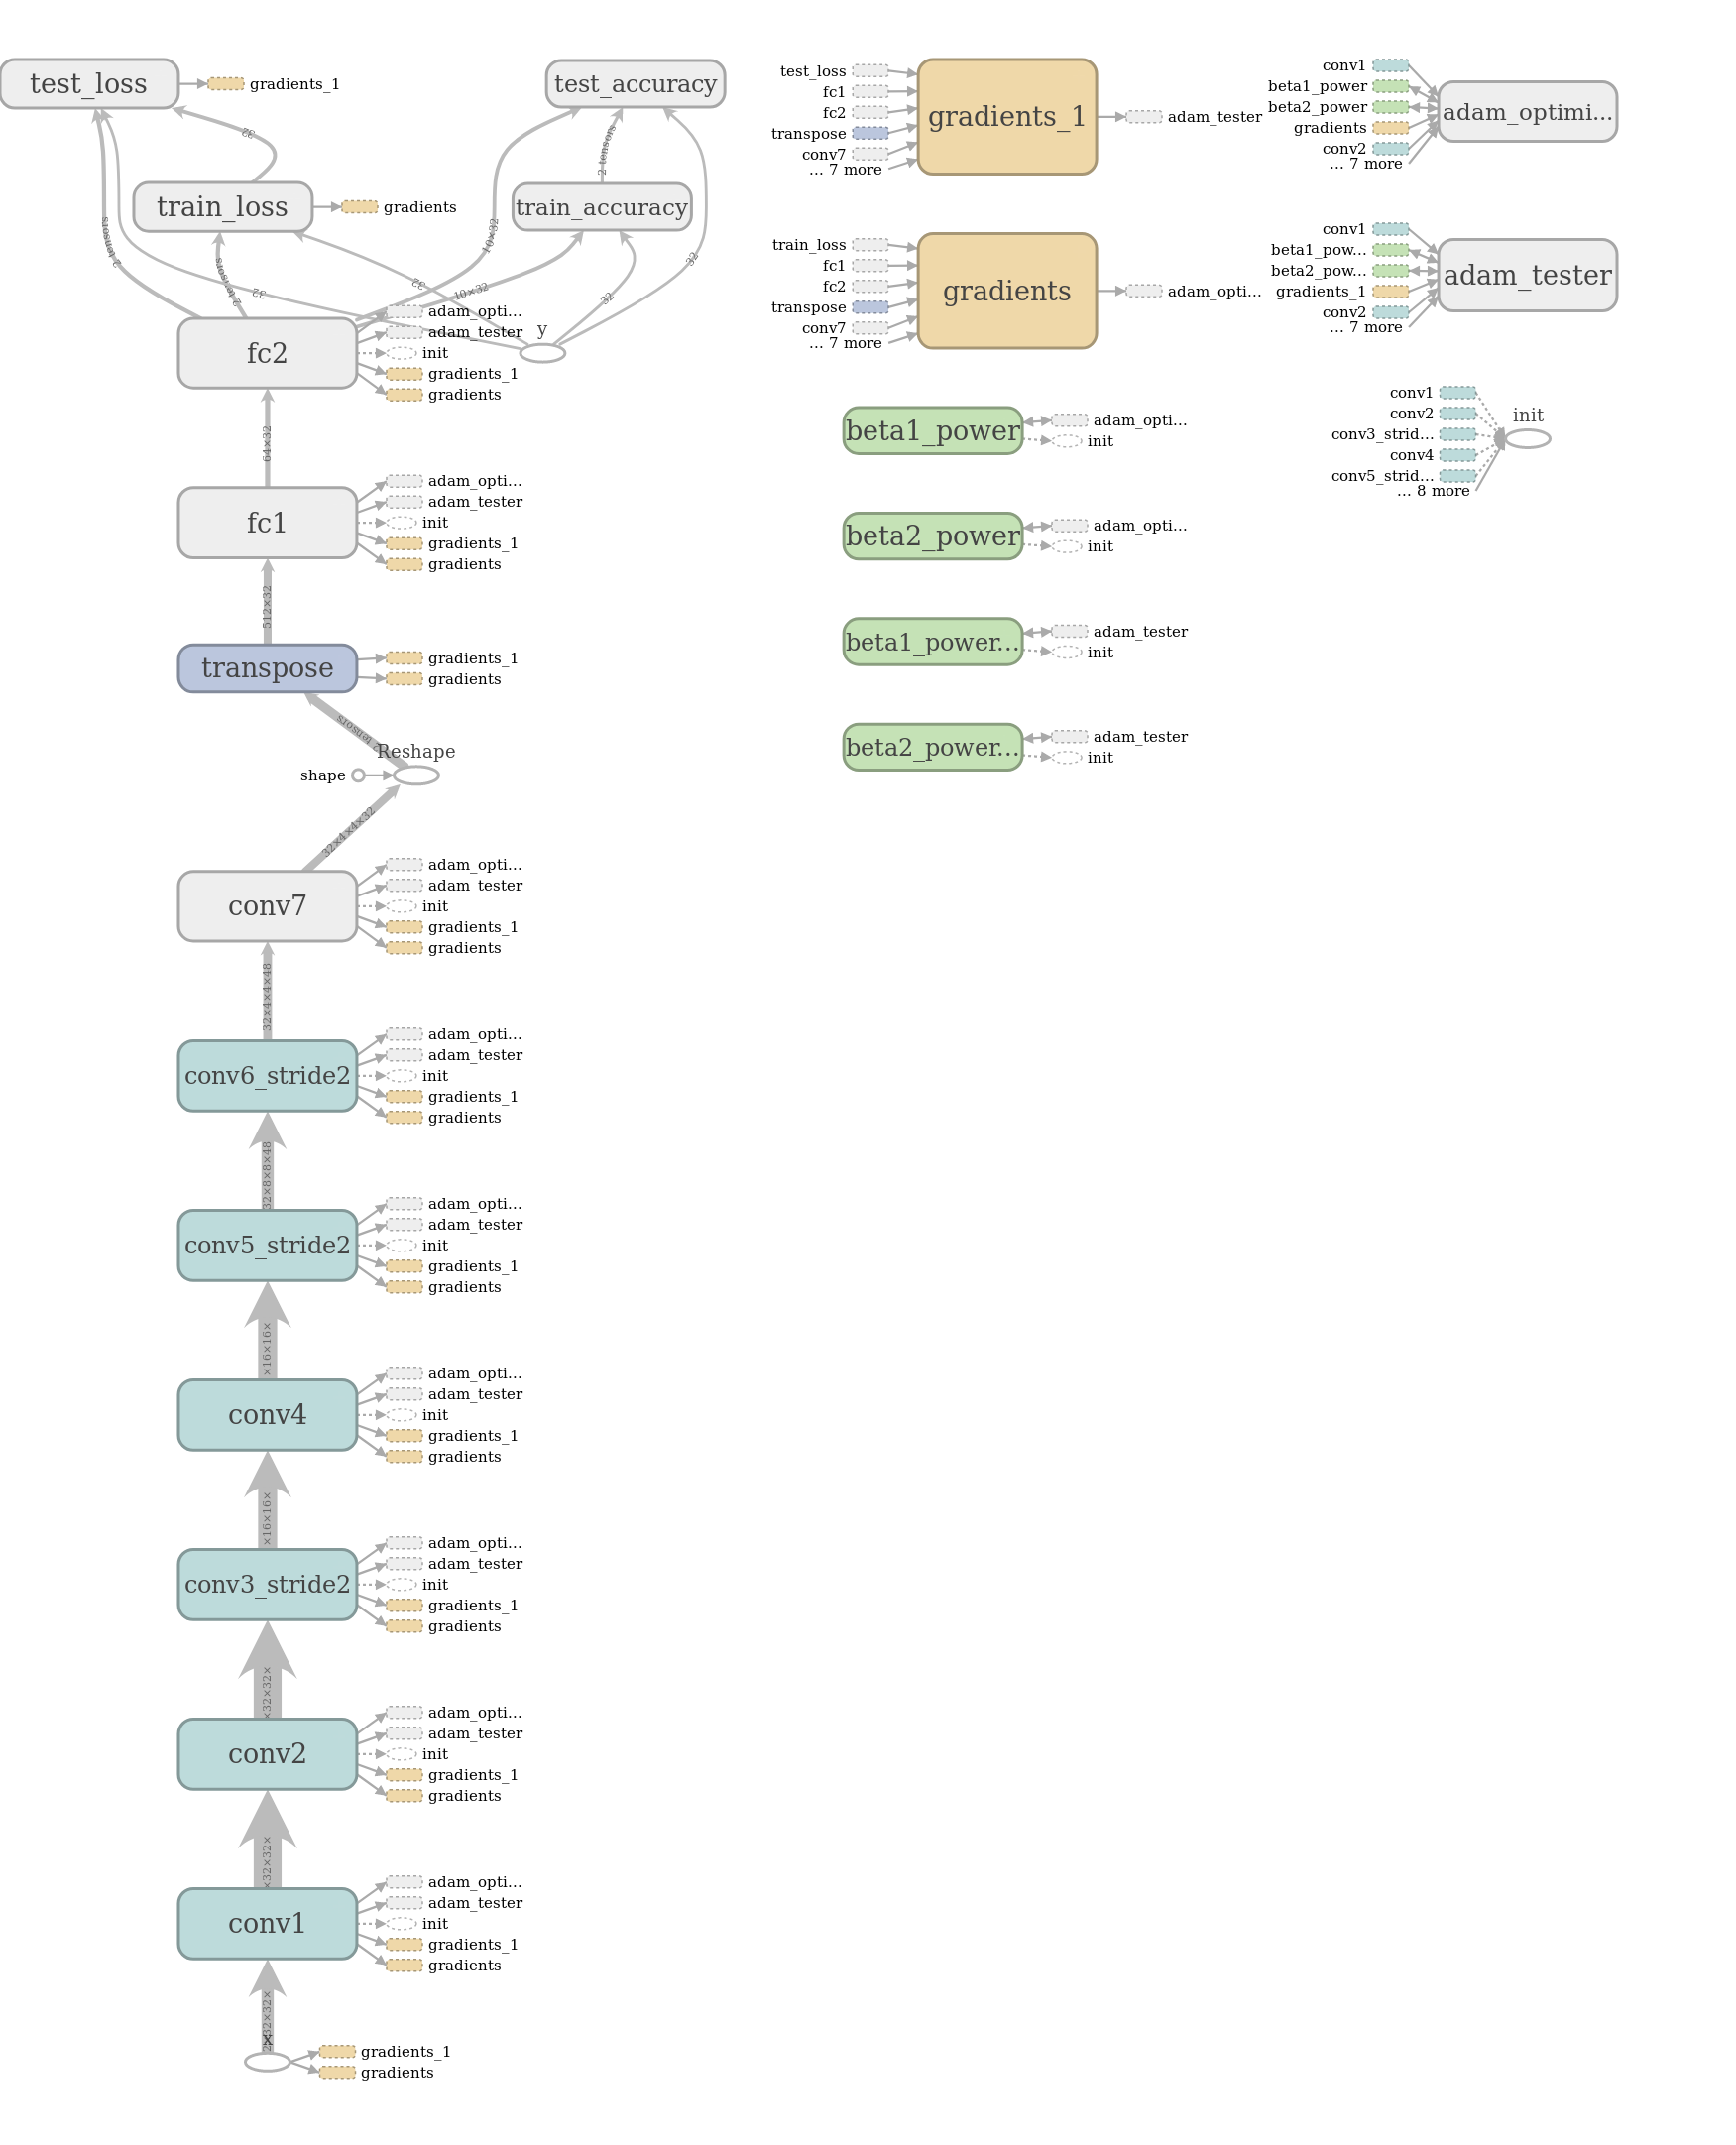

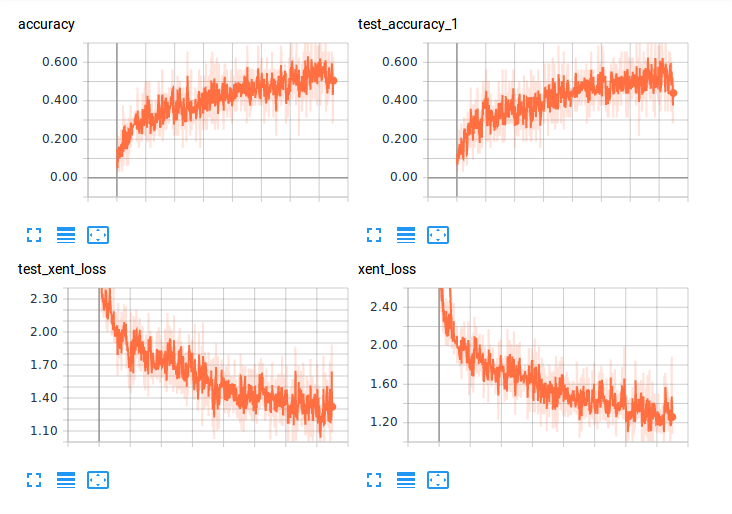

In [323]:
import PIL.Image as PILImage
from IPython.display import display, Image

display(PILImage.open('lab5_comp_graph'))
display(PILImage.open('lab5_graphs.png'))